# Rossmann Store Sales



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

import pylab
import csv
import datetime
import math
import re
import time
import random
import os

from pandas.tseries.offsets import *
from operator import *

from sklearn.cross_validation import train_test_split

%matplotlib inline

# plt.style.use('ggplot') # Good looking plots

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)

start_time = time.time()

C:\Users\Administrator\Anaconda2\envs\gl-env\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

## Setting seed

In [3]:
seed = 42

## Reading sales data

In [4]:
nrows = None

df_train = pd.read_csv('train.csv', 
                       nrows=nrows,
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

nrows = nrows

df_submit = pd.read_csv('test.csv', 
                        nrows=nrows,
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

C:\Users\Administrator\Anaconda2\envs\gl-env\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
### Setting a variable to easily distinguish train (1) from submit (0) set
df_train['Set'] = 1
df_submit['Set'] = 0

In [6]:
### Combine train and test set
frames = [df_train, df_submit]
df = pd.concat(frames)

In [10]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [11]:
### Remove rows where store is open, but no sales.
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [12]:
df.loc[df['Set'] == 1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['Sales']) # = np.log(df['Sales'] + 1)

In [13]:
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

In [14]:
var_name = 'Date'

df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear

df[var_name + 'Day'] = df[var_name + 'Day'].fillna(0)
df[var_name + 'Week'] = df[var_name + 'Week'].fillna(0)
df[var_name + 'Month'] = df[var_name + 'Month'].fillna(0)
df[var_name + 'Year'] = df[var_name + 'Year'].fillna(0)
df[var_name + 'DayOfYear'] = df[var_name + 'DayOfYear'].fillna(0)

features_x.remove(var_name)
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

In [17]:
df['DateInt'] = df['Date'].astype(np.int64)

In [18]:
df_store = pd.read_csv('store.csv', 
                       nrows=nrows)

In [20]:
### Convert Storetype and Assortment to numerical categories
df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes
df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes

In [22]:

### Convert competition open year and month to float
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

df_store['CompetitionOpenInt'] = df_store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [24]:
### Convert competition open year and month to float

def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan

df_store['Promo2SinceFloat'] = df_store.apply(lambda df: convertPromo2(df), axis=1).astype(np.int64)

In [25]:
s = df_store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_store = df_store.join(s)

In [26]:
def monthToNum(date):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[date]

df_store['PromoInterval0'] = df_store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval1'] = df_store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval2'] = df_store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval3'] = df_store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [27]:
del df_store['PromoInterval']

In [28]:
store_features = ['Store', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt',
                  'PromoInterval0']

### Features not helping
# PromoInterval1, PromoInterval2, PromoInterval3

features_x = list(set(features_x + store_features))

In [29]:
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [30]:
### Convert every NAN to -1
for feature in features_x:
    df[feature] = df[feature].fillna(-1)

In [41]:

store_dates_to_remove = {   105:1.368e18, 163:1.368e18,
                            172:1.366e18, 364:1.37e18,
                            378:1.39e18, 523:1.39e18,
                            589:1.37e18, 663:1.39e18,
                            676:1.366e18, 681:1.37e18,
                            700:1.373e18, 708:1.368e18,
                            709:1.423e18, 730:1.39e18,
                            764:1.368e18, 837:1.396e18,
                            845:1.368e18, 861:1.368e18,
                            882:1.368e18, 969:1.366e18,
                            986:1.368e18, 192:1.421e18,
                            263:1.421e18, 500:1.421e18,
                            797:1.421e18, 815:1.421e18,
                            825:1.421e18}

for key,value in store_dates_to_remove.iteritems():
    df.loc[(df['Store'] == key) & (df['DateInt'] < value), 'Delete'] = True

In [43]:
### Delete the data where sales in the first period is much different from the rest
df = df.loc[df['Delete'] != True]

In [44]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


In [45]:

for i in df['Store'].unique():
    df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y],
                                                    test_size=0.1, random_state=seed)

In [48]:

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [49]:
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [63]:
param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

plst = param.items()

bst = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

Will train until test error hasn't decreased in 250 rounds.
[0]	train-rmspe:0.999863	test-rmspe:0.999863
[250]	train-rmspe:0.491216	test-rmspe:0.487971
[500]	train-rmspe:0.198972	test-rmspe:0.188309
[750]	train-rmspe:0.166821	test-rmspe:0.156818
[1000]	train-rmspe:0.137129	test-rmspe:0.132996
[1250]	train-rmspe:0.122311	test-rmspe:0.121035
[1500]	train-rmspe:0.109952	test-rmspe:0.112465
[1750]	train-rmspe:0.100481	test-rmspe:0.106788
[2000]	train-rmspe:0.093883	test-rmspe:0.102796
[2250]	train-rmspe:0.088570	test-rmspe:0.100460
[2500]	train-rmspe:0.083871	test-rmspe:0.098587
[2750]	train-rmspe:0.080263	test-rmspe:0.097114
[3000]	train-rmspe:0.077273	test-rmspe:0.095896
[3250]	train-rmspe:0.074326	test-rmspe:0.094886
[3500]	train-rmspe:0.071833	test-rmspe:0.094089
[3750]	train-rmspe:0.069701	test-rmspe:0.093385
[4000]	train-rmspe:0.067834	test-rmspe:0.092811
[4250]	train-rmspe:0.066103	test-rmspe:0.092347
[4500]	train-rmspe:0.064509	test-rmspe:0.091941
[4750]	train-rmspe:0.062960	test-r

In [64]:
dpred = xgb.DMatrix(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True)][features_x])

In [65]:
ypred_bst = bst.predict(dpred)

In [66]:
df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'SalesLog'] = ypred_bst
df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'Sales'] = np.exp(ypred_bst) - 1

In [68]:

### Get total sales, customers and open days per store
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

In [69]:

### Calculate sales per day, customers per day and sales per customers per day
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

In [70]:
df_store = pd.merge(df_store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

In [71]:
store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

features_x = list(set(features_x + store_features))


In [72]:

df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1)][features_y],
                                                    test_size=0.1, random_state=seed)

In [74]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [75]:
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [76]:
param = {'bst:max_depth':12,
         'bst:eta':0.0095,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1, 
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

plst = param.items()

bst1 = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

Will train until test error hasn't decreased in 250 rounds.
[0]	train-rmspe:0.999866	test-rmspe:0.999865
[250]	train-rmspe:0.531137	test-rmspe:0.529227
[500]	train-rmspe:0.137918	test-rmspe:0.131062
[750]	train-rmspe:0.110675	test-rmspe:0.111607
[1000]	train-rmspe:0.100810	test-rmspe:0.106202
[1250]	train-rmspe:0.092724	test-rmspe:0.102566
[1500]	train-rmspe:0.087041	test-rmspe:0.099832
[1750]	train-rmspe:0.082683	test-rmspe:0.097939
[2000]	train-rmspe:0.078698	test-rmspe:0.096432
[2250]	train-rmspe:0.075622	test-rmspe:0.095216
[2500]	train-rmspe:0.072704	test-rmspe:0.094271
[2750]	train-rmspe:0.070362	test-rmspe:0.093525
[3000]	train-rmspe:0.068244	test-rmspe:0.092888
[3250]	train-rmspe:0.066329	test-rmspe:0.092319
[3500]	train-rmspe:0.064502	test-rmspe:0.091857
[3750]	train-rmspe:0.062939	test-rmspe:0.091523
[4000]	train-rmspe:0.061489	test-rmspe:0.091201
[4250]	train-rmspe:0.060084	test-rmspe:0.090915
[4500]	train-rmspe:0.058776	test-rmspe:0.090721
[4750]	train-rmspe:0.057532	test-r

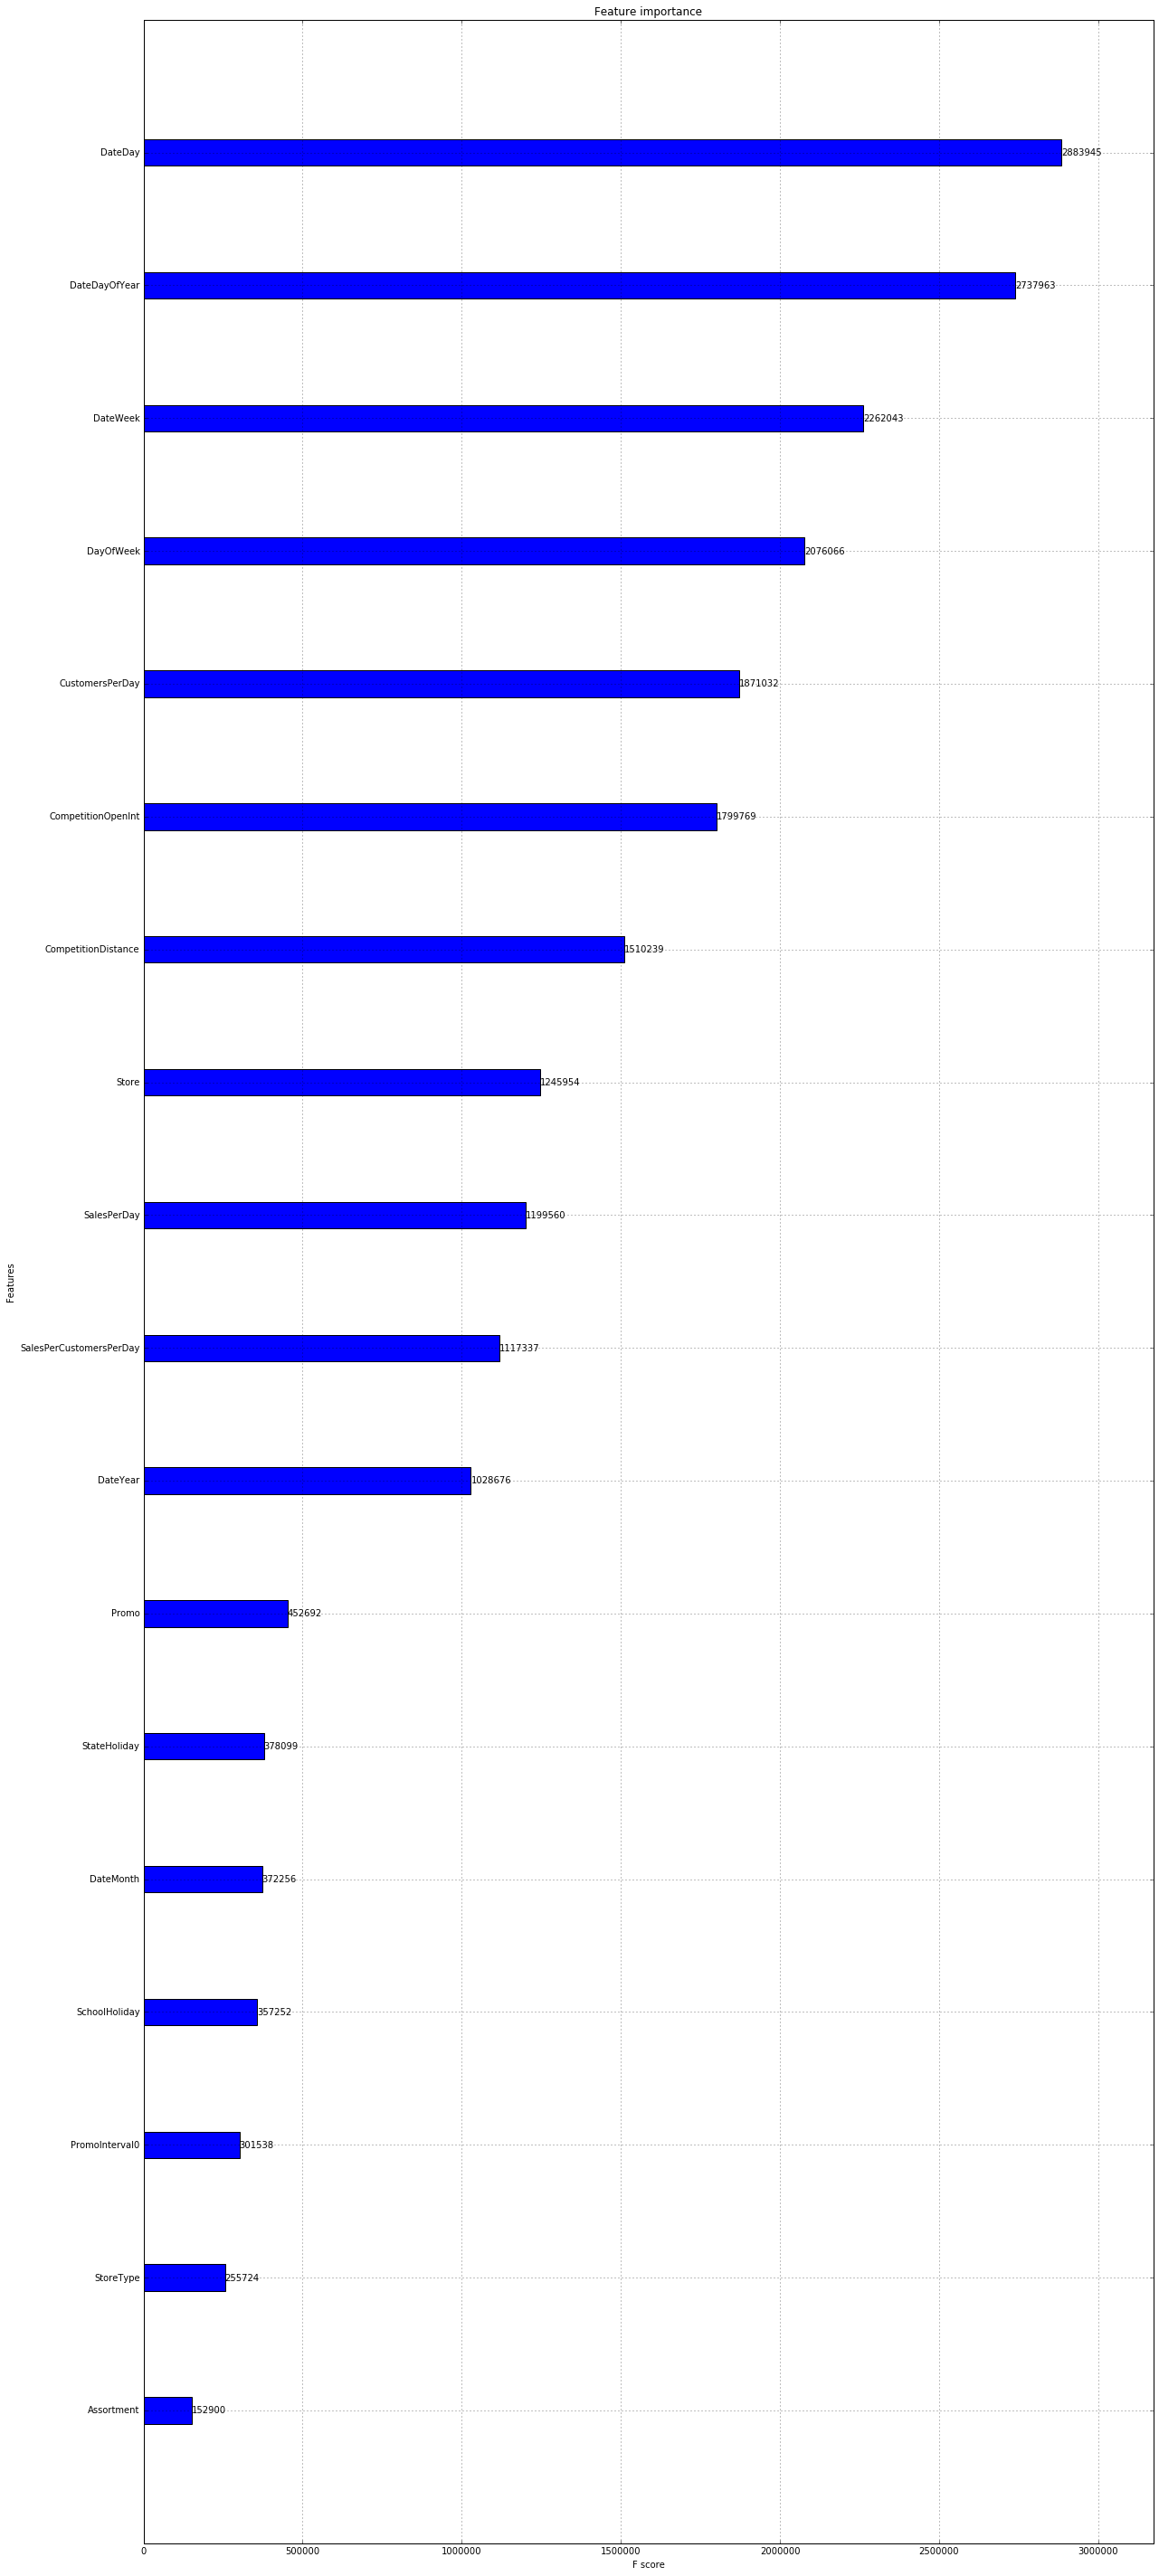

In [81]:
xgb.plot_importance(bst1)

In [78]:

X_submit = df.loc[df['Set'] == 0]

In [79]:

dsubmit = xgb.DMatrix(X_submit[features_x])

In [82]:
ypred_bst = bst1.predict(dsubmit)

df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

# Scale back the sales a bit
df_ypred['Sales'] = (np.exp(ypred_bst) - 1) * 0.985

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_best_no_ext_data_scaled.csv', index=False)